In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import ParameterGrid
from umap import UMAP
from hdbscan import HDBSCAN
import torch
import re
import warnings
from google.colab import drive
import os
from datetime import datetime
import pickle
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =============================================================================
# CONFIGURATION - MODIFY THESE SETTINGS
# =============================================================================

# DATASET OPTIONS
USE_FULL_DATASET = False  # Set to True to use full dataset, False for sample
SAMPLE_SIZE = 2000  # Only used if USE_FULL_DATASET = False

# CHECKPOINT SETTINGS (for full dataset processing)
CHECKPOINT_FREQUENCY = 5000  # Save checkpoint every N articles processed
CHECKPOINT_DIR = './checkpoints/'  # Directory to save checkpoints
ENABLE_CHECKPOINTING = True  # Set to False to disable checkpointing

# Create checkpoint directory if it doesn't exist
if ENABLE_CHECKPOINTING and not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
    print(f"Created checkpoint directory: {CHECKPOINT_DIR}")

print("=== CONFIGURATION ===")
print(f"Use full dataset: {USE_FULL_DATASET}")
print(f"Sample size: {SAMPLE_SIZE if not USE_FULL_DATASET else 'N/A'}")
print(f"Checkpointing enabled: {ENABLE_CHECKPOINTING}")
print(f"Checkpoint frequency: {CHECKPOINT_FREQUENCY if ENABLE_CHECKPOINTING else 'N/A'}")


=== CONFIGURATION ===
Use full dataset: False
Sample size: 2000
Checkpointing enabled: True
Checkpoint frequency: 5000


In [ ]:
# =============================================================================
# CHECKPOINTING UTILITIES
# =============================================================================

def save_checkpoint(data, checkpoint_name, step_description):
    """Save checkpoint with timestamp and description"""
    if not ENABLE_CHECKPOINTING:
        return

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_name}_{timestamp}.parquet"
    filepath = os.path.join(CHECKPOINT_DIR, filename)

    try:
        data.to_parquet(filepath, index=False)
        print(f"Checkpoint saved: {filename} ({step_description})")
        print(f"Location: {filepath}")
        print(f"Size: {len(data)} rows")

        # Also save a "latest" version for easy loading
        latest_filepath = os.path.join(CHECKPOINT_DIR, f"{checkpoint_name}_latest.parquet")
        data.to_parquet(latest_filepath, index=False)

    except Exception as e:
        print(f"Failed to save checkpoint {filename}: {e}")

def load_latest_checkpoint(checkpoint_name):
    """Load the latest checkpoint if it exists"""
    if not ENABLE_CHECKPOINTING:
        return None

    latest_filepath = os.path.join(CHECKPOINT_DIR, f"{checkpoint_name}_latest.parquet")

    if os.path.exists(latest_filepath):
        try:
            data = pd.read_parquet(latest_filepath)
            print(f"Loaded checkpoint: {checkpoint_name}_latest.parquet")
            print(f"Size: {len(data)} rows")
            return data
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")
            return None
    else:
        print(f"No existing checkpoint found for {checkpoint_name}")
        return None


In [ ]:
# =============================================================================
# GPU SETUP AND VERIFICATION
# =============================================================================

def setup_gpu():
    """Setup and verify GPU availability"""
    print("=== GPU SETUP ===")

    # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_count = torch.cuda.device_count()
        current_gpu = torch.cuda.current_device()
        gpu_name = torch.cuda.get_device_name(current_gpu)

        print(f"   GPU acceleration available!")
        print(f"   Device: {device}")
        print(f"   GPU Count: {gpu_count}")
        print(f"   Current GPU: {current_gpu}")
        print(f"   GPU Name: {gpu_name}")
        print(f"   GPU Memory: {torch.cuda.get_device_properties(current_gpu).total_memory / 1024**3:.1f} GB")

        # Clear GPU cache
        torch.cuda.empty_cache()

        return device, True
    else:
        print("GPU not available, falling back to CPU")
        return torch.device("cpu"), False

# Setup GPU
device, gpu_available = setup_gpu()

=== GPU SETUP ===
GPU not available, falling back to CPU


In [ ]:
# === Load cleaned dataset ===
df = pd.read_csv("cleaned_ai_articles.csv", engine='pyarrow')

In [ ]:
# =============================================================================
# DATA LOADING AND SAMPLING
# =============================================================================

def load_and_prepare_data():
    """Load dataset and create sample or use full dataset based on configuration"""
    print("\n=== DATA LOADING ===")

    print(f"Loaded dataset: {len(df)} articles")

    # Add year column for temporal analysis
    df['year'] = pd.to_datetime(df['date']).dt.year
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")

    if USE_FULL_DATASET:
        print("Using FULL DATASET")
        df_working = df.copy()

        # Check for existing preprocessing checkpoint
        checkpoint_data = load_latest_checkpoint("preprocessed_data")
        if checkpoint_data is not None:
            user_input = input("Found existing preprocessed checkpoint. Use it? (y/n): ").lower()
            if user_input == 'y':
                return checkpoint_data

    else:
        print(f"Using SAMPLE of {SAMPLE_SIZE} articles")

        # Create stratified sample to maintain temporal distribution
        yearly_props = df['year'].value_counts(normalize=True).sort_index()

        sample_dfs = []
        for year, prop in yearly_props.items():
            year_data = df[df['year'] == year]
            year_sample_size = int(SAMPLE_SIZE * prop)
            if year_sample_size > 0:
                year_sample = year_data.sample(n=min(year_sample_size, len(year_data)), random_state=13)
                sample_dfs.append(year_sample)

        df_working = pd.concat(sample_dfs, ignore_index=True)
        print(f"Sample created: {len(df_working)} articles ({len(df_working)/len(df)*100:.2f}% of total)")

    # Create combined text
    print("Creating combined text...")
    df_working['combined_text'] = df_working['title'] + " " + df_working['text']

    # Save initial checkpoint for full dataset
    if USE_FULL_DATASET and ENABLE_CHECKPOINTING:
        save_checkpoint(df_working, "initial_data", "Initial data with combined text")

    return df_working

In [ ]:
# =============================================================================
# BATCH PROCESSING FOR LARGE DATASETS
# =============================================================================

def process_in_batches(df_working, topic_model, batch_size=5000):
    """Process large datasets in batches with checkpointing"""
    print(f"\n=== BATCH PROCESSING ===")
    print(f"Processing {len(df_working)} articles in batches of {batch_size}")

    all_topics = []
    all_probabilities = []
    processed_count = 0

    # Process in batches
    for i in range(0, len(df_working), batch_size):
        batch_end = min(i + batch_size, len(df_working))
        batch_df = df_working.iloc[i:batch_end].copy()

        print(f"Processing batch {i//batch_size + 1}/{(len(df_working)-1)//batch_size + 1}")
        print(f"Articles {i+1} to {batch_end} ({len(batch_df)} articles)")

        # Get documents for this batch
        documents = batch_df['combined_text'].tolist()

        # Process batch
        if i == 0:
            # First batch - fit the model
            print("Fitting model on first batch...")
            batch_topics, batch_probabilities = topic_model.fit_transform(documents)
        else:
            # Subsequent batches - transform only
            print("Transforming batch...")
            batch_topics, batch_probabilities = topic_model.transform(documents)

        # Store results
        all_topics.extend(batch_topics)
        if batch_probabilities is not None:
            all_probabilities.extend(batch_probabilities)

        processed_count += len(batch_df)

        # Save checkpoint periodically
        if ENABLE_CHECKPOINTING and processed_count % CHECKPOINT_FREQUENCY == 0:
            # Create temporary results dataframe for checkpoint
            temp_df = df_working.iloc[:processed_count].copy()
            temp_df['topic'] = all_topics
            if all_probabilities:
                temp_df['topic_probability'] = all_probabilities

            save_checkpoint(temp_df, "partial_results", f"Processed {processed_count} articles")

        # Clear GPU memory
        if gpu_available:
            torch.cuda.empty_cache()

        print(f"Batch completed. Total processed: {processed_count}/{len(df_working)}")

    return all_topics, all_probabilities

def process_lda_in_batches(texts, vectorizer, lda_model, batch_size=5000):
    """Transform LDA topic distributions in batches"""
    print("\n=== PROCESSING LDA IN BATCHES ===")
    all_topics = []
    total_batches = (len(texts) - 1) // batch_size + 1
    for i in range(total_batches):
        start = i * batch_size
        end = start + batch_size
        batch_texts = texts[start:end]
        print(f"Processing LDA batch {i + 1}/{total_batches} ({len(batch_texts)} documents)")
        X_batch = vectorizer.transform(batch_texts)
        batch_topic_dist = lda_model.transform(X_batch)
        all_topics.append(batch_topic_dist)
    all_topics = np.vstack(all_topics)
    print("Completed LDA batch processing.")
    return all_topics

In [ ]:
# =============================================================================
# MODEL SETUP
# =============================================================================

def setup_bertopic_model():
    """Setup BERTopic model based on configuration"""
    print(f"\n=== BERTOPIC MODEL SETUP ===")

    # Choose model based on dataset size and GPU availability
    if gpu_available:
        if USE_FULL_DATASET:
            print("Full dataset + GPU: Using high-performance model")
            embedding_model = SentenceTransformer('all-mpnet-base-v2')
        else:
            print("Sample + GPU: Using high-performance model")
            embedding_model = SentenceTransformer('all-mpnet-base-v2')
        embedding_model = embedding_model.to('cuda')
    else:
        print("CPU mode: Using lighter model")
        embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Adjust parameters based on dataset size
    if USE_FULL_DATASET:
        min_cluster_size = 100  # Larger clusters for full dataset
        max_features = 2000
        min_df = 10
    else:
        min_cluster_size = 50   # Smaller clusters for sample
        max_features = 1000
        min_df = 3

    # Customize UMAP for better topic separation
    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric='cosine',
        random_state=13
    )

    # Customize HDBSCAN for topic clustering
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True
    )

    # Customize CountVectorizer for better topic representation
    vectorizer_model = CountVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        min_df=min_df,
        max_df=0.95,
        max_features=max_features
    )

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
    )

    print("BERTopic model initialized successfully!")
    return topic_model

def setup_lda_vectorizer(df_texts, max_df=0.95, min_df=5, max_features=1000):
    print("\n=== FITTING LDA VECTORIZER ===")
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_df=max_df,
        min_df=min_df,
        max_features=max_features
    )
    vectorizer.fit(df_texts)
    print(f"Vectorizer fitted with vocab size: {len(vectorizer.vocabulary_)}")
    return vectorizer

def setup_lda_model_from_vectorized(X, num_topics=10):
    print(f"\n=== FITTING LDA MODEL WITH {num_topics} TOPICS ===")
    lda_model = LatentDirichletAllocation(
        n_components=num_topics,
        max_iter=10,
        learning_method='batch',
        random_state=13
    )
    lda_model.fit(X)
    print("LDA model fitted successfully!")
    return lda_model


In [ ]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""

    # Load and prepare data
    df_working = load_and_prepare_data()

    # Setup BERTopic model
    topic_model = setup_bertopic_model()

    print(f"\n=== TOPIC MODELING ===")
    start_time = datetime.now()

    if USE_FULL_DATASET and len(df_working) > 10000:
        # Use batch processing for large datasets
        topics, probabilities = process_in_batches(df_working, topic_model, batch_size=CHECKPOINT_FREQUENCY)
    else:
        # Process all at once for smaller datasets
        print("Fitting BERTopic model...")
        documents = df_working['combined_text'].tolist()
        topics, probabilities = topic_model.fit_transform(documents)

    # ===== LDA MODEL =====
    lda_vectorizer = setup_lda_vectorizer(
        df_working['combined_text'],
        max_df=0.95,
        min_df=3 if not USE_FULL_DATASET else 10,
        max_features=1000 if not USE_FULL_DATASET else 2000
    )

    X = lda_vectorizer.transform(df_working['combined_text'])

    lda_model = setup_lda_model_from_vectorized(
        X,
        num_topics=10 if not USE_FULL_DATASET else 25
    )

    lda_topic_distributions = process_lda_in_batches(
        df_working['combined_text'].tolist(),
        lda_vectorizer,
        lda_model,
        batch_size=5000
    )

    df_working['lda_topic'] = lda_topic_distributions.argmax(axis=1)

    end_time = datetime.now()
    processing_time = (end_time - start_time).total_seconds()

    print(f"Topic modeling completed!")
    print(f"Processing time: {processing_time/60:.1f} minutes")
    print(f"Topics found: {len(set(topics))}")
    print(f"Outliers (topic -1): {sum(1 for t in topics if t == -1)}")

    # Add BERTopic results to dataframe
    df_working['topic'] = topics
    if isinstance(probabilities, (list, np.ndarray)) and len(probabilities) == len(df_working):
        df_working['topic_probability'] = probabilities

    # Save final checkpoint
    if ENABLE_CHECKPOINTING:
        save_checkpoint(df_working, "final_results", "Complete topic modeling results")

    return df_working, topic_model, topics, probabilities, lda_vectorizer, lda_model


In [ ]:
def analyze_and_visualize(df_working, topic_model, topics, probabilities,
                        lda_topic_distributions=None, lda_num_topics=None):
    """Analyze results and create visualizations for BERTopic and LDA"""

    print(f"\n=== BERTopic ANALYSIS ===")

    # --- BERTopic summary & visualization ---
    topic_info = topic_model.get_topic_info()
    print("Top 10 Topics by Size:")
    print(topic_info.head(10)[['Topic', 'Count', 'Name']])

    def create_topic_name(topic_words, max_words=3):
        if not topic_words:
            return "Miscellaneous"
        top_words = [word for word, _ in topic_words[:max_words]]
        return " & ".join(top_words).title()

    topic_details = []
    for topic_id in range(len(set(topics)) - 1):  # Exclude -1 (outliers)
        topic_words = topic_model.get_topic(topic_id)
        topic_name = create_topic_name(topic_words)
        topic_count = sum(1 for t in topics if t == topic_id)

        topic_details.append({
            'Topic_ID': topic_id,
            'Topic_Name': topic_name,
            'Article_Count': topic_count,
            'Percentage': (topic_count / len(df_working)) * 100,
            'Top_Words': [word for word, _ in topic_words[:5]]
        })

    topic_df = pd.DataFrame(topic_details).sort_values('Article_Count', ascending=False)

    print("\nDetailed Topic Information:")
    for _, row in topic_df.head(10).iterrows():
        print(f"Topic {row['Topic_ID']}: {row['Topic_Name']} ({row['Article_Count']} articles, {row['Percentage']:.2f}%)")
        print(f"  Top words: {', '.join(row['Top_Words'])}")
        print()

    # Plot BERTopic results
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    topic_counts = pd.Series(topics).value_counts().head(15)
    topic_counts = topic_counts[topic_counts.index != -1]

    axes[0, 0].bar(range(len(topic_counts)), topic_counts.values, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('BERTopic: Top 15 Topics by Article Count', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Topic ID')
    axes[0, 0].set_ylabel('Number of Articles')
    axes[0, 0].set_xticks(range(len(topic_counts)))
    axes[0, 0].set_xticklabels(topic_counts.index)

    df_working['year_month'] = pd.to_datetime(df_working['date']).dt.to_period('M')
    topic_time = df_working.groupby(['year_month', 'topic']).size().unstack(fill_value=0)

    top_topics = topic_counts.head(5).index
    topic_time_top = topic_time[top_topics]

    for i, topic_id in enumerate(top_topics):
        axes[0, 1].plot(topic_time_top.index.astype(str), topic_time_top[topic_id],
                        marker='o', label=f'Topic {topic_id}', linewidth=2)

    axes[0, 1].set_title('BERTopic: Top 5 Topics Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Number of Articles')
    axes[0, 1].legend()

    # Show only every 3rd month label on x-axis for BERTopic trend plot
    all_months = topic_time_top.index.astype(str).tolist()
    tick_positions = list(range(0, len(all_months), 3))
    tick_labels = [all_months[i] for i in tick_positions]
    axes[0, 1].set_xticks(tick_positions)
    axes[0, 1].set_xticklabels(tick_labels)
    axes[0, 1].tick_params(axis='x', rotation=45)

    if probabilities is not None and len(probabilities) > 0:
        valid_probs = [p for p in probabilities if p > 0]
        if valid_probs:
            axes[1, 0].hist(valid_probs, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[1, 0].axvline(np.mean(valid_probs), color='red', linestyle='--',
                               label=f'Mean: {np.mean(valid_probs):.3f}')
            axes[1, 0].legend()

    axes[1, 0].set_title('BERTopic: Topic Assignment Probability Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Probability')
    axes[1, 0].set_ylabel('Frequency')

    outliers_time = df_working[df_working['topic'] == -1].groupby('year_month').size()
    if len(outliers_time) > 0:
        axes[1, 1].plot(outliers_time.index.astype(str), outliers_time.values,
                        marker='o', color='red', linewidth=2)
        axes[1, 1].set_title('BERTopic: Outlier Articles Over Time', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Month')
        axes[1, 1].set_ylabel('Number of Outlier Articles')

        # Show every 3rd month label for outliers plot
        outlier_months = outliers_time.index.astype(str).tolist()
        outlier_tick_positions = list(range(0, len(outlier_months), 3))
        outlier_tick_labels = [outlier_months[i] for i in outlier_tick_positions]
        axes[1, 1].set_xticks(outlier_tick_positions)
        axes[1, 1].set_xticklabels(outlier_tick_labels)
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        axes[1, 1].text(0.5, 0.5, 'No outliers found', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('BERTopic: Outlier Articles Over Time', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # --- LDA analysis and visualization ---
    if lda_topic_distributions is not None and lda_num_topics is not None:
        print(f"\n=== LDA ANALYSIS ===")

        lda_topics = lda_topic_distributions
        lda_counts = pd.Series(lda_topics).value_counts().sort_index()

        print("LDA Topic Counts:")
        for topic_id, count in lda_counts.items():
            print(f"Topic {topic_id}: {count} articles")

        # --- Print top words per LDA topic ---
        print("\nTop words per LDA topic:")
        feature_names = lda_vectorizer.get_feature_names_out()
        n_top_words = 5  # how many top words you want to print
        for topic_idx, topic in enumerate(lda_model.components_):
            top_indices = topic.argsort()[::-1][:n_top_words]
            top_words = [feature_names[i] for i in top_indices]
            print(f"Topic {topic_idx}: {', '.join(top_words)}")

        # Plot LDA topic counts
        plt.figure(figsize=(12, 6))
        lda_counts.plot(kind='bar', color='coral', edgecolor='black')
        plt.title('LDA: Topic Counts')
        plt.xlabel('Topic ID')
        plt.ylabel('Number of Articles')
        plt.show()

        # LDA topic trends over time
        df_working['lda_topic'] = lda_topics
        lda_topic_time = df_working.groupby(['year_month', 'lda_topic']).size().unstack(fill_value=0)

        top_lda_topics = lda_counts.head(5).index
        lda_topic_time_top = lda_topic_time[top_lda_topics]

        plt.figure(figsize=(12, 6))
        for topic_id in top_lda_topics:
            plt.plot(lda_topic_time_top.index.astype(str), lda_topic_time_top[topic_id],
                     marker='o', label=f'LDA Topic {topic_id}', linewidth=2)

        plt.title('LDA: Top 5 Topics Over Time')
        plt.xlabel('Month')
        plt.ylabel('Number of Articles')
        plt.legend()

        # Show only every 3rd month label for LDA plot
        all_months_lda = lda_topic_time_top.index.astype(str).tolist()
        tick_positions_lda = list(range(0, len(all_months_lda), 3))
        tick_labels_lda = [all_months_lda[i] for i in tick_positions_lda]
        plt.xticks(ticks=tick_positions_lda, labels=tick_labels_lda, rotation=45)

        plt.tight_layout()
        plt.show()

    return topic_df


In [ ]:
import joblib  # Make sure this import is at the top of your script

def save_final_results(df_working, topic_model, topic_df, lda_model=None, lda_vectorizer=None):
    """Save all final results including BERTopic and optionally LDA model and vectorizer"""
    print(f"\n=== SAVING RESULTS ===")

    # Save the BERTopic model
    model_name = "bertopic_model_full" if USE_FULL_DATASET else "bertopic_model_sample"
    topic_model.save(model_name)
    print(f"BERTopic model saved as '{model_name}'")

    # Save the working dataset with topics
    data_name = "full_with_topics.parquet" if USE_FULL_DATASET else "sample_with_topics.parquet"
    df_working.to_parquet(data_name, index=False)
    print(f"Data with topics saved as '{data_name}'")

    # Save topic mapping
    mapping_name = "topic_mapping_full.csv" if USE_FULL_DATASET else "topic_mapping_sample.csv"
    topic_df.to_csv(mapping_name, index=False)
    print(f"Topic mapping saved as '{mapping_name}'")

    # Save the LDA model and vectorizer if provided
    if lda_model is not None:
        lda_model_name = "lda_model_full.joblib" if USE_FULL_DATASET else "lda_model_sample.joblib"
        joblib.dump(lda_model, lda_model_name)
        print(f"LDA model saved as '{lda_model_name}'")

    if lda_vectorizer is not None:
        lda_vectorizer_name = "lda_vectorizer_full.joblib" if USE_FULL_DATASET else "lda_vectorizer_sample.joblib"
        joblib.dump(lda_vectorizer, lda_vectorizer_name)
        print(f"LDA vectorizer saved as '{lda_vectorizer_name}'")

    # Save to Google Drive for backup
    drive_dir = './topic_modeling_results/'
    if not os.path.exists(drive_dir):
        os.makedirs(drive_dir)

    # Copy results to Drive
    df_working.to_parquet(os.path.join(drive_dir, data_name), index=False)
    topic_df.to_csv(os.path.join(drive_dir, mapping_name), index=False)

    if lda_model is not None:
        lda_drive_path = os.path.join(drive_dir, lda_model_name)
        joblib.dump(lda_model, lda_drive_path)
        print(f"LDA model backed up to Google Drive as '{lda_model_name}'")

    if lda_vectorizer is not None:
        lda_vectorizer_drive_path = os.path.join(drive_dir, lda_vectorizer_name)
        joblib.dump(lda_vectorizer, lda_vectorizer_drive_path)
        print(f"LDA vectorizer backed up to Google Drive as '{lda_vectorizer_name}'")

    print(f"Results backed up to Google Drive")


STARTING TOPIC MODELING PIPELINE

=== DATA LOADING ===
Loaded dataset: 147052 articles
Date range: 2022-01-01 to 2025-07-22
Using SAMPLE of 2000 articles
Sample created: 1999 articles (1.36% of total)
Creating combined text...

=== BERTOPIC MODEL SETUP ===
CPU mode: Using lighter model


2025-08-07 08:35:41,448 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic model initialized successfully!

=== TOPIC MODELING ===
Fitting BERTopic model...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-08-07 08:40:22,655 - BERTopic - Embedding - Completed ✓
2025-08-07 08:40:22,658 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-07 08:40:33,656 - BERTopic - Dimensionality - Completed ✓
2025-08-07 08:40:33,659 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-07 08:40:33,779 - BERTopic - Cluster - Completed ✓
2025-08-07 08:40:33,783 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-07 08:40:44,570 - BERTopic - Representation - Completed ✓



=== FITTING LDA VECTORIZER ===
Vectorizer fitted with vocab size: 1000

=== FITTING LDA MODEL WITH 10 TOPICS ===
LDA model fitted successfully!

=== PROCESSING LDA IN BATCHES ===
Processing LDA batch 1/1 (1999 documents)
Completed LDA batch processing.
Topic modeling completed!
Processing time: 5.3 minutes
Topics found: 5
Outliers (topic -1): 528
Checkpoint saved: final_results_20250807_084100.parquet (Complete topic modeling results)
Location: /content/drive/My Drive/checkpoints/final_results_20250807_084100.parquet
Size: 1999 rows

=== BERTopic ANALYSIS ===
Top 10 Topics by Size:
   Topic  Count                                       Name
0     -1    528           -1_lg_share price_ment_entertain
1      0    954              0_galaxy_windows 11_intel_uae
2      1    281                1_npr_public file_ap_donate
3      2    132    2_newswires_presswire_ein_ein presswire
4      3    104  3_symbols_currently available_fool_motley

Detailed Topic Information:
Topic 0: Galaxy & Windows 1

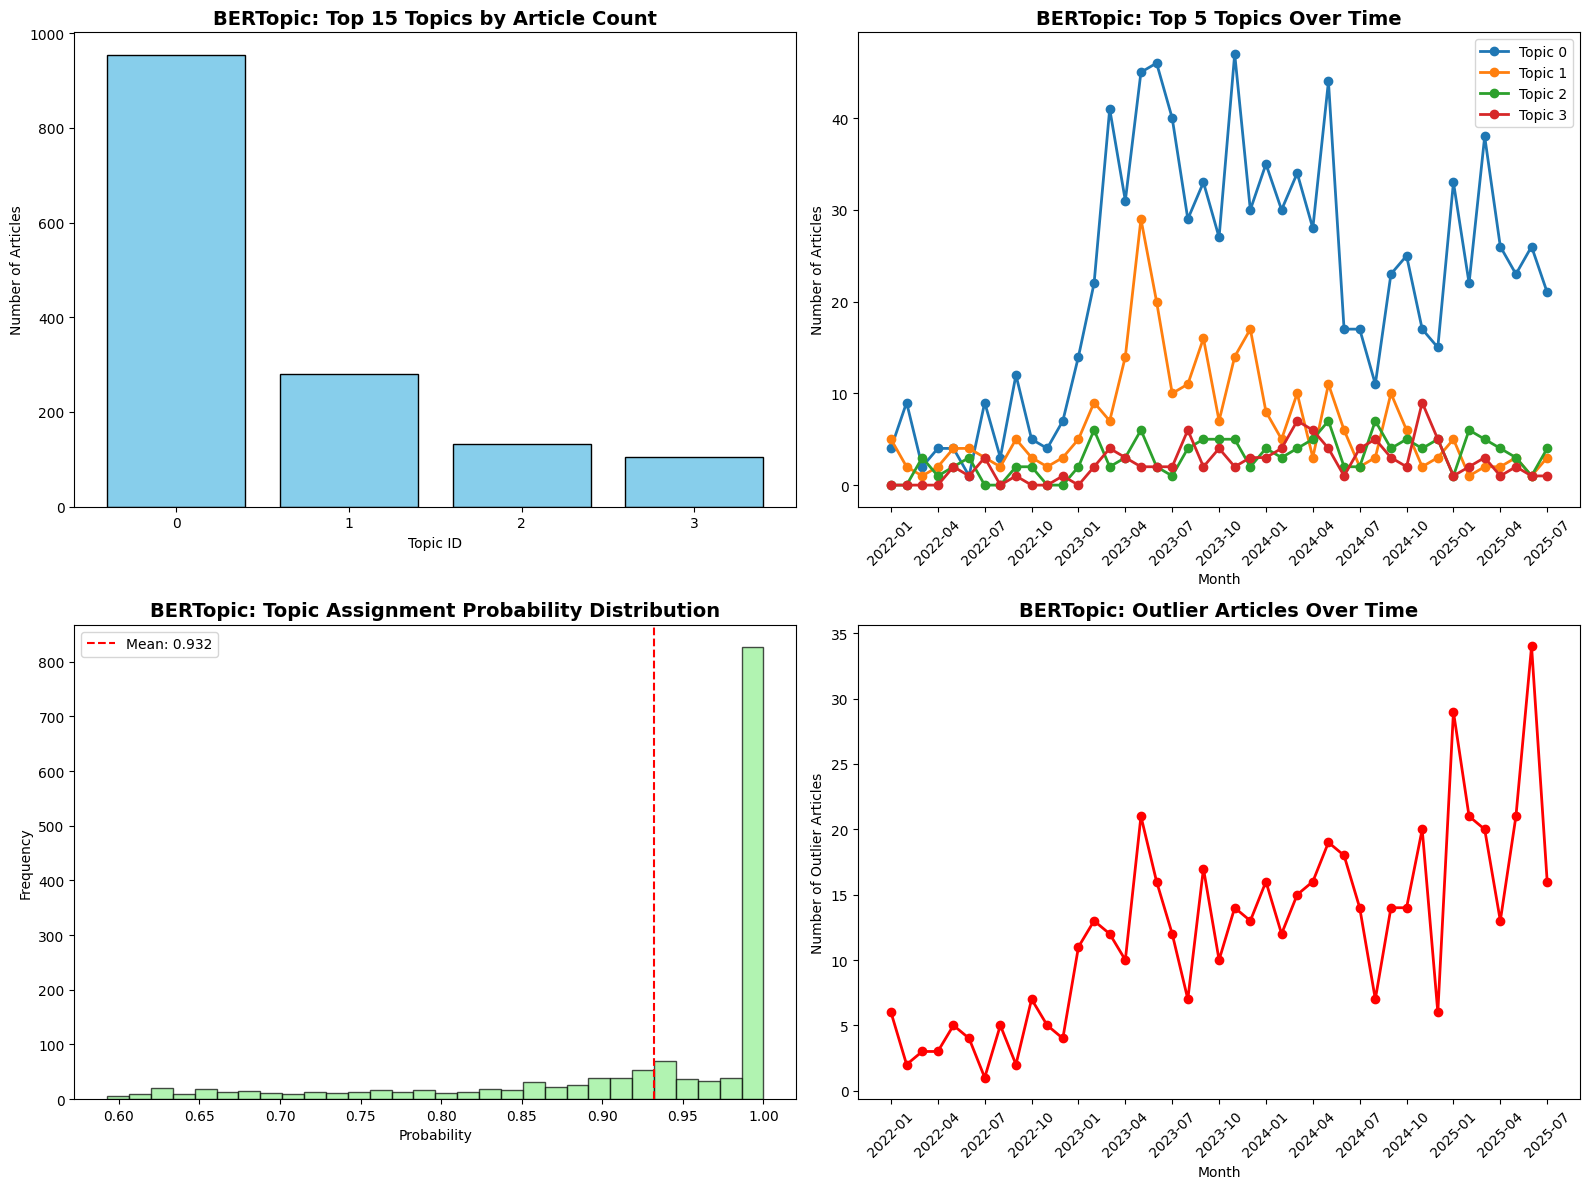


=== LDA ANALYSIS ===
LDA Topic Counts:
Topic 0: 1 articles
Topic 3: 86 articles
Topic 5: 1 articles
Topic 6: 1847 articles
Topic 7: 63 articles
Topic 8: 1 articles

Top words per LDA topic:
Topic 0: newswires, presswire, ein, releases, distribution
Topic 1: developed, symbols, old, february, feb
Topic 2: developed, symbols, old, february, feb
Topic 3: nasdaq, stock, stocks, market, price
Topic 4: ago, hours, weather, file, ap
Topic 5: republic, market, currencies, stocks, indices
Topic 6: ai, news, new, 2023, data
Topic 7: npr, salary, radio, schedule, donate
Topic 8: data, agents, ai, healthcare, statements
Topic 9: developed, symbols, old, february, feb


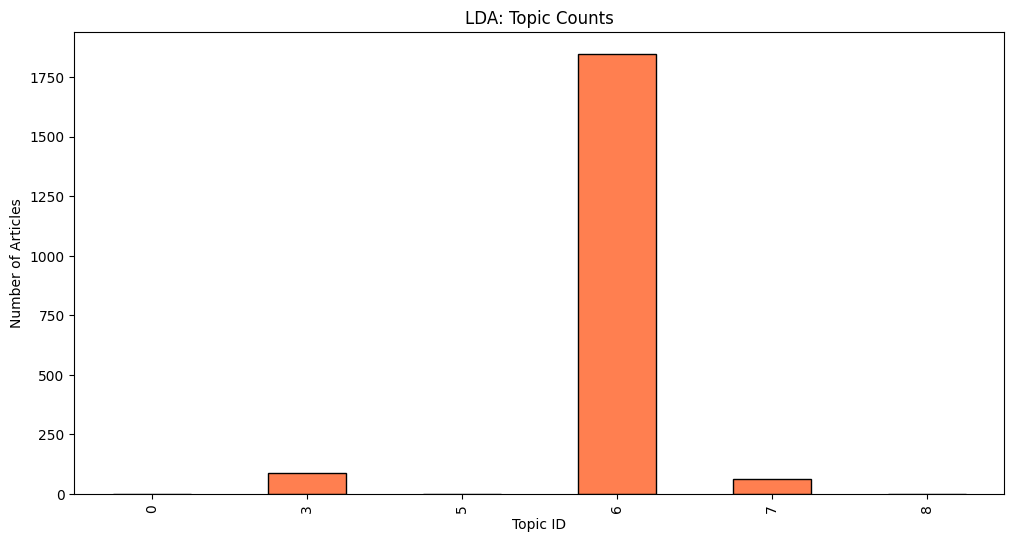

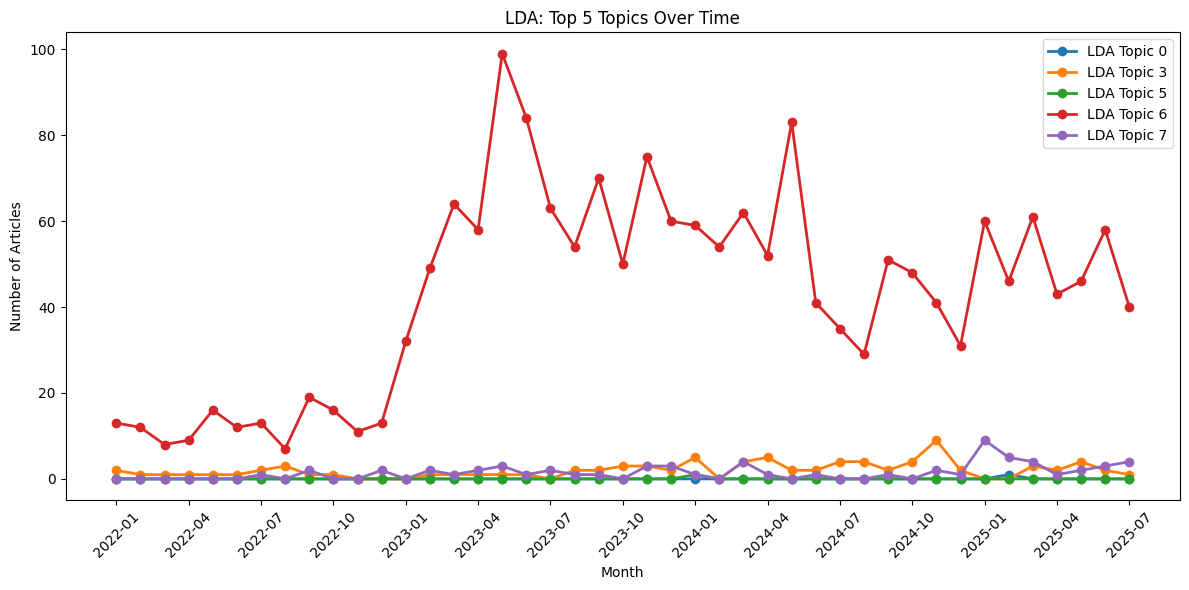

2025-08-07 08:41:02,711 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



=== SAVING RESULTS ===
BERTopic model saved as 'bertopic_model_sample'
Data with topics saved as 'sample_with_topics.parquet'
Topic mapping saved as 'topic_mapping_sample.csv'
LDA model saved as 'lda_model_sample.joblib'
LDA vectorizer saved as 'lda_vectorizer_sample.joblib'
LDA model backed up to Google Drive as 'lda_model_sample.joblib'
LDA vectorizer backed up to Google Drive as 'lda_vectorizer_sample.joblib'
Results backed up to Google Drive
TOPIC MODELING PIPELINE COMPLETED SUCCESSFULLY!

Final Summary:
- Dataset used: Sample of 2000
- Articles processed: 1999
- Topics discovered: 4
- Outliers: 528 (26.4%)
- Checkpoints saved: 9


In [ ]:
# =============================================================================
# RUN THE COMPLETE PIPELINE
# =============================================================================

if __name__ == "__main__":
    print("STARTING TOPIC MODELING PIPELINE")

    try:
        # Step 1: Run main pipeline to get processed data and models
        df_working, topic_model, topics, probabilities, lda_vectorizer, lda_model = main()

        # Step 2: Perform analysis and visualization, pass LDA results as well
        topic_df = analyze_and_visualize(
            df_working,
            topic_model,
            topics,
            probabilities,
            lda_topic_distributions=df_working['lda_topic'].to_numpy(),
            lda_num_topics=10 if not USE_FULL_DATASET else 25
        )

        # Step 3: Save all results including LDA model
        save_final_results(df_working, topic_model, topic_df, lda_vectorizer, lda_model)

        print("TOPIC MODELING PIPELINE COMPLETED SUCCESSFULLY!")

        # Final summary printout
        print(f"\nFinal Summary:")
        print(f"- Dataset used: {'Full dataset' if USE_FULL_DATASET else f'Sample of {SAMPLE_SIZE}'}")
        print(f"- Articles processed: {len(df_working)}")
        print(f"- Topics discovered: {len(set(topics)) - (1 if -1 in topics else 0)}")
        print(f"- Outliers: {sum(1 for t in topics if t == -1)} ({sum(1 for t in topics if t == -1)/len(topics)*100:.1f}%)")
        print(f"- Checkpoints saved: {len([f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.parquet')]) if ENABLE_CHECKPOINTING and os.path.exists(CHECKPOINT_DIR) else 0}")

    except Exception as e:
        print(f"\nERROR in pipeline: {e}")
        print("Check the logs above for details.")
        raise
